In [ ]:
!pwd

/content


In [ ]:
import os 
if os.path.exists('/content/GaussCNNTest') is False: 
  os.chdir('/content')
  os.system('git clone https://github.com/dptru10/GaussCNNTest.git') 

In [ ]:
%cd /content/GaussCNNTest

/content/GaussCNNTest


In [ ]:
import os
import time
import copy
import glob 
import torch
import random
import numpy as np
import matplotlib
import torchvision
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from PIL import Image as im
from model import Gauss2D

In [ ]:
show        = True 
pretrain    = False
data_dir    = 'data'
filename    = 'model_out_gauss.pth'
batch_size  = 20       #Number of samples in each batch
num_workers = 4
epoch_num   = 5        #Number of epochs to train the network
lr          = 0.01     # Learning rate

In [ ]:
data_transforms = {
    'train': transforms.ToTensor(),
    'val': transforms.ToTensor()
}
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=num_workers)
               for x in ['train', 'val']}
print(len(dataloaders['train']))
print(len(dataloaders['val']))

180
20


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device) 

cuda


In [ ]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

#Gauss2D.imshow(out,title=[class_names[x] for x in classes], fname='initial.jpg',show=False)


model_ft = models.resnet18(pretrained=pretrain)
if torch.cuda.device_count() > 1: 
    print("Using ", torch.cuda.device_count(),"gpus!")
    model_ft = nn.DataParallel(model_ft) #
    
model_ft=model_ft.to(device)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=lr, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)
model_ft = Gauss2D.train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=epoch_num, dataloaders=dataloaders, device=device,dataset_sizes=dataset_sizes)
torch.save(model_ft, filename)

#Gauss2D.visualize_model(model_ft,num_images=4,device=device,dataloaders=dataloaders,class_names=class_names)

Epoch 0/4
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


train Loss: 0.3296 Acc: 0.9192
val Loss: 0.1042 Acc: 0.9598

Epoch 1/4
----------
train Loss: 0.1296 Acc: 0.9553
val Loss: 0.0993 Acc: 0.9648

Epoch 2/4
----------
train Loss: 0.1281 Acc: 0.9564
val Loss: 0.0858 Acc: 0.9724

Epoch 3/4
----------
train Loss: 0.1245 Acc: 0.9575
val Loss: 0.0938 Acc: 0.9698

Epoch 4/4
----------
train Loss: 0.1089 Acc: 0.9575
val Loss: 0.0626 Acc: 0.9774

Training complete in 0m 26s
Best val Acc: 0.977387


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[[199   0]
 [  9 190]]
[100.          95.47738693]


Text(0.5, 1.0, 'Confusion Matrix')

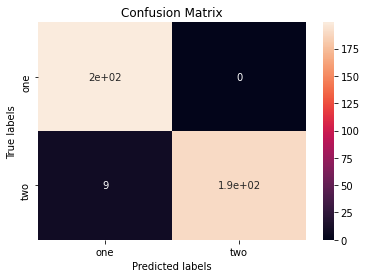

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns 
import pandas as pd 

nb_classes = 2

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['val']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)

        # Append batch prediction results
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,classes.view(-1).cpu()])

# Confusion matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
print(conf_mat)

# Per-class accuracy
class_accuracy=100*conf_mat.diagonal()/conf_mat.sum(1)
print(class_accuracy)
labels = ['one','two']
ax= plt.subplot()


sns.heatmap(conf_mat, annot=True)
class_names = np.asarray(labels)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_xticklabels(class_names.flatten())
ax.set_yticklabels(class_names.flatten())
ax.set_title('Confusion Matrix')